# Name: Nhat Minh Dang
# ID: 222172836
# SIT 378 

# Impact of Low Quality Audio

## 1) Imported library:
These are the library required to process the data:
Note that the code only work when the Model is saved in the code directory. 

In [3]:
import librosa
import librosa.display
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import scipy.signal
from scipy.io import wavfile

## 2) Setting:
These are the parameters that is required to run the code. You can add as many desired classes as possible (remember to adjust in Accuracy Calcuation function). The frequency range is set based on my suggestion for the best outcome:

In [5]:
audio_directory_path = "Sound/Aslan"
desired_class = "Roaring cats (lions, tigers)"
desired_class_1 = ""
desired_class_2 = ""
min_db = 0
max_db = 81
range_db = 5

# 3) File Check:
To check whether the input directory is correct or not, the code below will count the number of files found in that directory.

In [7]:
def count_files_in_directory(directory_path):
    try:
        all_items = os.listdir(directory_path)
        files = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))]
        return len(files)
    except FileNotFoundError:
        print(f"Directory not found: {directory_path}")
        return 0
    except PermissionError:
        print(f"Permission denied to access: {directory_path}")
        return 0

file_count = count_files_in_directory(audio_directory_path)
print(f"Number of files in '{audio_directory_path}': {file_count}")


Number of files in 'Sound/Aslan': 45


# 4) Basic Codes:
These are the basic code to produce the standard result for comparison, which includes:
- Audio processing: Load audio file and resample it, followed by clipping the waveform amplitude from -1 to 1 for normalization.\
- Load the YAMNet model in the saved directory.
- Load the class Map.
- Perform preduction.
- Compute the score and return the most probability prediction.
- Process all audio files (in .wav format).
- Feature visualization: Demonstrate audio files in Waveform, Log Mel Spectrogram and Frequency Spectrogram.
- Calculate accuracy: Check and count the result that match the setting above.

In [9]:
def preprocess_audio(file_path, target_sample_rate=16000):
    """
    Load and preprocess the audio file by applying a bandstop filter to remove a specific frequency range.
    Args:
        file_path (str): Path to the audio file.
        target_sample_rate (int): Desired sample rate for the audio.
    Returns:
        audio (numpy.ndarray): The preprocessed audio signal.
    """
    audio, sr = librosa.load(file_path, sr=target_sample_rate)
    audio = np.clip(audio, -1.0, 1.0)
    return audio

def load_yamnet_model(model_path='Model'):
    """
    Load the YAMNet model from the local directory.
    Args:
        model_path (str): Path to the directory containing the YAMNet model.
    Returns:
        model: Loaded YAMNet model.
    """
    model = hub.load(model_path)
    return model


def load_class_map(file_path='Model/assets/yamnet_class_map.csv'):
    """
    Load the class labels map from a CSV file.
    Args:
        file_path (str): Path to the CSV file containing the class map.
    Returns:
        dict: A dictionary mapping class indices to class names.
    """
    class_map = {}
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  
        
        for row in reader:
            class_index = int(row[0]) 
            class_name = row[2]       
            class_map[class_index] = class_name
    
    return class_map

def predict_with_yamnet(model, waveform):
    scores, embeddings, log_mel_spectrogram = model(waveform)
    return scores, embeddings, log_mel_spectrogram

def aggregate_scores(scores):
    aggregated_scores = np.mean(scores, axis=0)
    return aggregated_scores

def get_top_prediction(aggregated_scores, class_map):
    top_index = np.argmax(aggregated_scores)
    top_class = class_map[top_index]
    top_probability = aggregated_scores[top_index]   
    return top_class, top_probability

def process_audio_directory(directory_path, yamnet_model, class_map):
    """
    Process all .wav audio files in the given directory.
    Args:
        directory_path (str): Path to the directory containing .wav files.
        yamnet_model: The YAMNet model instance.
        class_map (dict): Mapping of class indices to class names.
    Returns:
        results (list): List of tuples containing file name, predicted class, and probability.
    """
    results = []
    wav_files = glob.glob(os.path.join(directory_path, '*.wav'))
    
    for wav_file in wav_files:
        try:
            waveform = preprocess_audio(wav_file)
            scores, embeddings, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
            aggregated_scores = aggregate_scores(scores)
            top_class, top_probability = get_top_prediction(aggregated_scores, class_map)
            results.append((os.path.basename(wav_file), top_class, top_probability))      
        except Exception as e:
            print(f"Error processing file {wav_file}: {e}")
    
    return results


def display_audio_features(waveform, log_mel_spectrogram, file_name):
    """
    Displays the waveform, log mel spectrogram, frequency spectrum, and MFCC for a given audio file.
    Args:
        waveform (numpy.ndarray): The waveform of the audio.
        log_mel_spectrogram (tensorflow.Tensor or numpy.ndarray): The log mel spectrogram.
        sample_rate (int): The sampling rate of the audio.
        file_name (str): Name of the audio file.
    """
    sample_rate = 16000
    if isinstance(log_mel_spectrogram, tf.Tensor):
        log_mel_spectrogram = log_mel_spectrogram.numpy()
    n = len(waveform)
    freq_spectrum = np.abs(np.fft.fft(waveform))[:n // 2]
    frequencies = np.fft.fftfreq(n, 1 / sample_rate)[:n // 2]
    
    plt.figure(figsize=(16, 12))
    
    plt.subplot(4, 1, 1)
    plt.plot(waveform, color='blue')
    plt.title(f"Waveform - {file_name}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    
    # plt.subplot(4, 1, 2)
    # plt.imshow(log_mel_spectrogram.T, aspect='auto', origin='lower', cmap='viridis')
    # plt.title(f"Log Mel Spectrogram - {file_name}")
    # plt.xlabel("Frames")
    # plt.ylabel("Mel Bands")
    
    # plt.subplot(4, 1, 3)
    # plt.plot(frequencies, freq_spectrum, color='green')
    # plt.title(f"Frequency Spectrum - {file_name}")
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Amplitude")
    # plt.xlim(0, sample_rate // 2) 
    
    plt.subplots_adjust(hspace=0.4)  
    plt.tight_layout()
    plt.show()
    
def calculate_accuracy(results):
    """
    Calculate the accuracy using collected result
    Args:
        results: Result collected.
    Returns:
        acc: Accuracy.
    """
    correct = 0
    acc = 0
    try:
        for file_name, predicted_class, probability in results:
            if predicted_class == desired_class or predicted_class == "Animal":
                correct += 1
        acc = correct / len(results) * 100
    except Exception as e:
            print(f"Error processing file: {e}")
    return acc



# 5) Execution code: 
These are the code to execute the function above, which includes processing files, model and display the first 3 examples:



Results:
File: aslan_1.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.6607


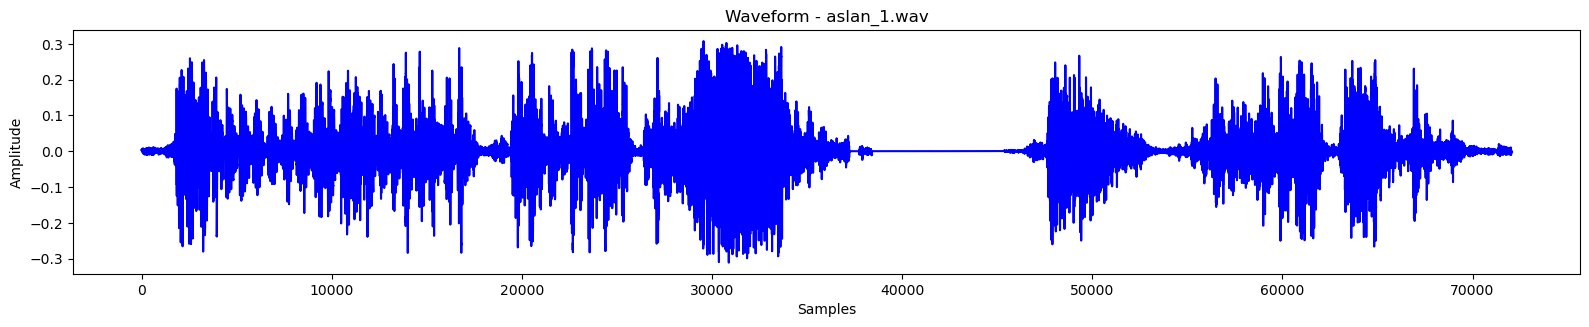

File: aslan_10.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.9941


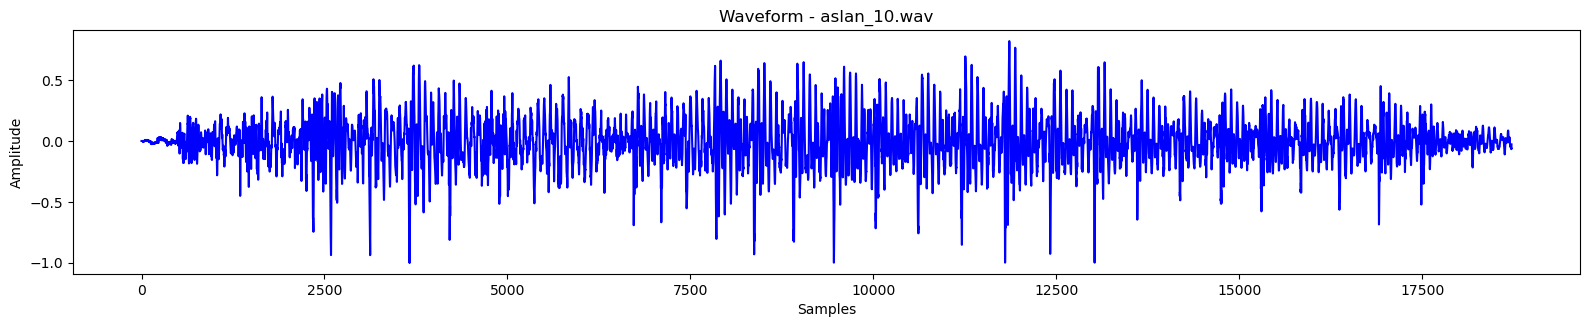

File: aslan_11.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.4172


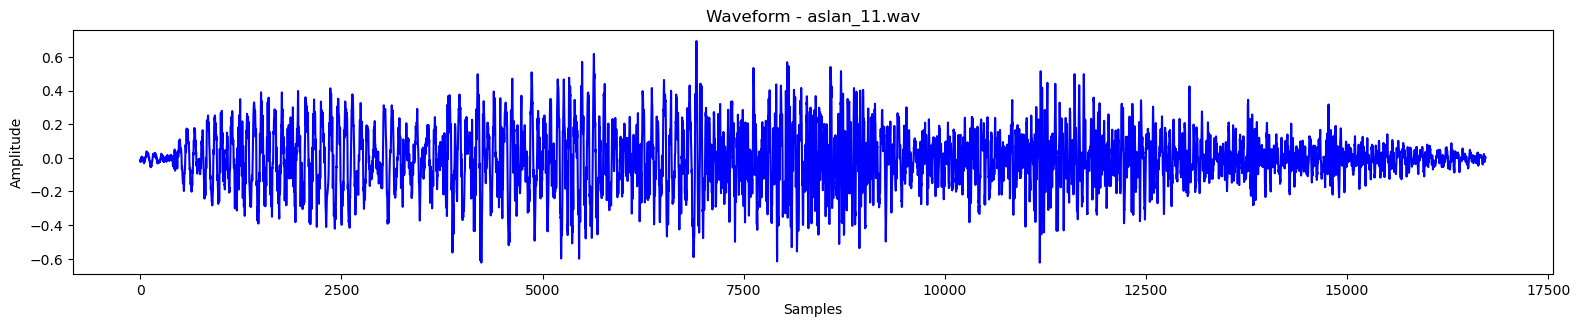

File: aslan_12.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.5964
File: aslan_13.wav - Predicted Class: Animal - Probability: 0.5781
File: aslan_14.wav - Predicted Class: Animal - Probability: 0.8432
File: aslan_15.wav - Predicted Class: Vehicle - Probability: 0.2488
File: aslan_16.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.7273
File: aslan_17.wav - Predicted Class: Animal - Probability: 0.7273
File: aslan_18.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.8477
File: aslan_19.wav - Predicted Class: Roar - Probability: 0.6806
File: aslan_2.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.9782
File: aslan_20.wav - Predicted Class: Animal - Probability: 0.5475
File: aslan_21.wav - Predicted Class: Animal - Probability: 0.7315
File: aslan_22.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.7273
File: aslan_23.wav - Predicted Class: Animal - Probability: 0.7273
File: aslan_24.wav - 

In [11]:
yamnet_model = load_yamnet_model()
class_map = load_class_map()

results = process_audio_directory(audio_directory_path, yamnet_model, class_map)

print("Results:")
for i, (file_name, predicted_class, probability) in enumerate(results):
    print(f"File: {file_name} - Predicted Class: {predicted_class} - Probability: {probability:.4f}")
    if i < 3:
        waveform = preprocess_audio(os.path.join(audio_directory_path, file_name))
        _, _, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
        display_audio_features(waveform, log_mel_spectrogram, file_name)

In [12]:
print(f"Model Accuracy of: {audio_directory_path}")
print(calculate_accuracy(results))

Model Accuracy of: Sound/Aslan
88.88888888888889


# 6) Testing with different methods:
These are the functions that I will use to apply size reduction method:
- **Reduce_bit_depth(file_path, bit_depth)**: Reduces the bit depth of an audio file to a specified level (e.g., 8 or 4 bits).
- **Convert_to_mono(file_path)**: Converts stereo audio to mono by combining the left and right channels.
- **trim_silence(file_path, top_db=20)**: Trims silence from the beginning and end of an audio file based on a threshold in decibels.
- **test_modified_preprocessing(directory_path, yamnet_model, class_map, method, **kwargs)**: Tests the YAMNet model on audio files in a directory using a specified preprocessing method.

In [14]:
def reduce_bit_depth(file_path, bit_depth):
    """
    Reduce the bit depth of the audio file.
    Args:
        file_path (str): Path to the audio file.
        bit_depth (int): Desired bit depth (e.g., 8 or 4).
    Returns:
        reduced_audio (numpy.ndarray): The reduced bit depth audio signal.
    """
    audio, sr = librosa.load(file_path, sr=None)
    max_val = 2 ** (bit_depth - 1) - 1
    reduced_audio = np.round(audio * max_val) / max_val
    reduced_audio = np.clip(reduced_audio, -1.0, 1.0)
    return reduced_audio, sr


In [15]:
def convert_to_mono(file_path):
    """
    Convert stereo audio to mono.
    Args:
        file_path (str): Path to the audio file.
    Returns:
        mono_audio (numpy.ndarray): The mono audio signal.
    """
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    return audio, sr


In [16]:
def trim_silence(file_path, top_db=20):
    """
    Trim silence from the audio file.
    Args:
        file_path (str): Path to the audio file.
        top_db (int): Threshold in decibels for silence trimming.
    Returns:
        trimmed_audio (numpy.ndarray): The trimmed audio signal.
    """
    audio, sr = librosa.load(file_path, sr=None)
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)
    return trimmed_audio, sr


In [17]:
def test_modified_preprocessing(directory_path, yamnet_model, class_map, method, **kwargs):
    """
    Test the model using modified preprocessing methods.
    Args:
        directory_path (str): Path to the directory containing .wav files.
        yamnet_model: The YAMNet model instance.
        class_map (dict): Mapping of class indices to class names.
        method (function): Preprocessing method to apply.
        kwargs: Additional arguments for the preprocessing method.
    Returns:
        results (list): List of tuples containing file name, predicted class, and probability.
    """
    results = []
    wav_files = glob.glob(os.path.join(directory_path, '*.wav'))
    
    for wav_file in wav_files:
        try:
            waveform, sr = method(wav_file, **kwargs)
            waveform = np.clip(waveform, -1.0, 1.0)  # Ensure the waveform is normalized
            scores, embeddings, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
            aggregated_scores = aggregate_scores(scores)
            top_class, top_probability = get_top_prediction(aggregated_scores, class_map)
            results.append((os.path.basename(wav_file), top_class, top_probability))      
        except Exception as e:
            print(f"Error processing file {wav_file}: {e}")
    
    return results


In [18]:
for bit_depth in [4, 8]:
    print(f"\nTesting with reduced bit depth ({bit_depth}-bit):")
    results = test_modified_preprocessing(audio_directory_path, yamnet_model, class_map, reduce_bit_depth, bit_depth=bit_depth)
    print(f"Accuracy for {bit_depth}-bit reduction:")
    print(calculate_accuracy(results))

print("\nTesting with mono conversion:")
results = test_modified_preprocessing(audio_directory_path, yamnet_model, class_map, convert_to_mono)
print("Accuracy for mono conversion:")
print(calculate_accuracy(results))

print("\nTesting with trimmed silence:")
results = test_modified_preprocessing(audio_directory_path, yamnet_model, class_map, trim_silence, top_db=20)
print("Accuracy for silence trimming:")
print(calculate_accuracy(results))



Testing with reduced bit depth (4-bit):
Accuracy for 4-bit reduction:
20.0

Testing with reduced bit depth (8-bit):
Accuracy for 8-bit reduction:
82.22222222222221

Testing with mono conversion:
Accuracy for mono conversion:
73.33333333333333

Testing with trimmed silence:
Accuracy for silence trimming:
75.55555555555556


# 7) Visualizing the result after using each of those method:
Below is my demonstration of audio files after using each of the methods above.

Visualizing audio transformations...

Visualizing Reduced Bit Depth (4-bit):


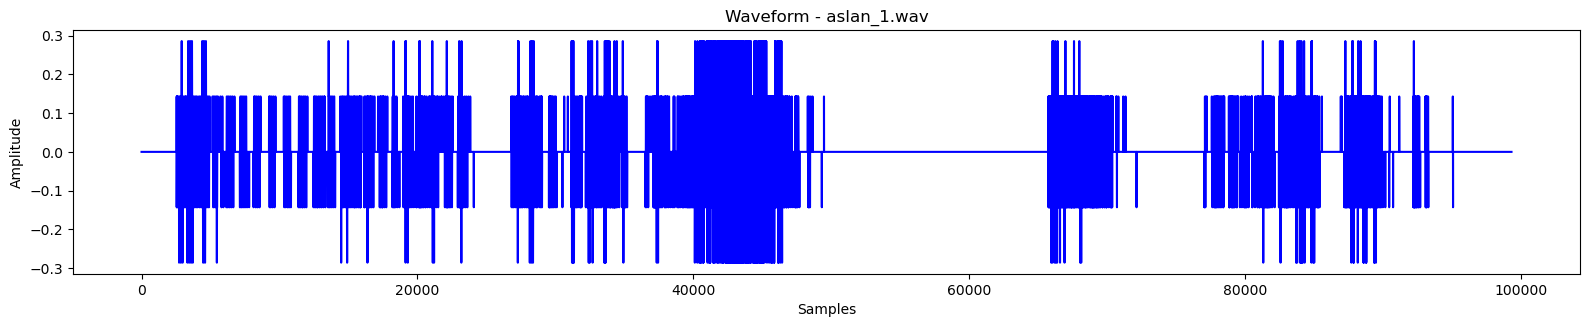


Visualizing Reduced Bit Depth (8-bit):


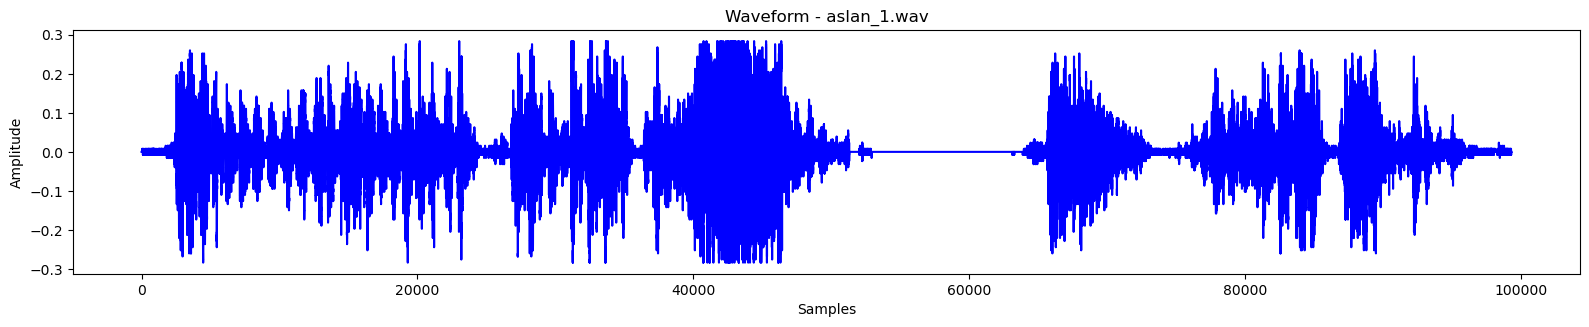


Visualizing Mono Conversion:


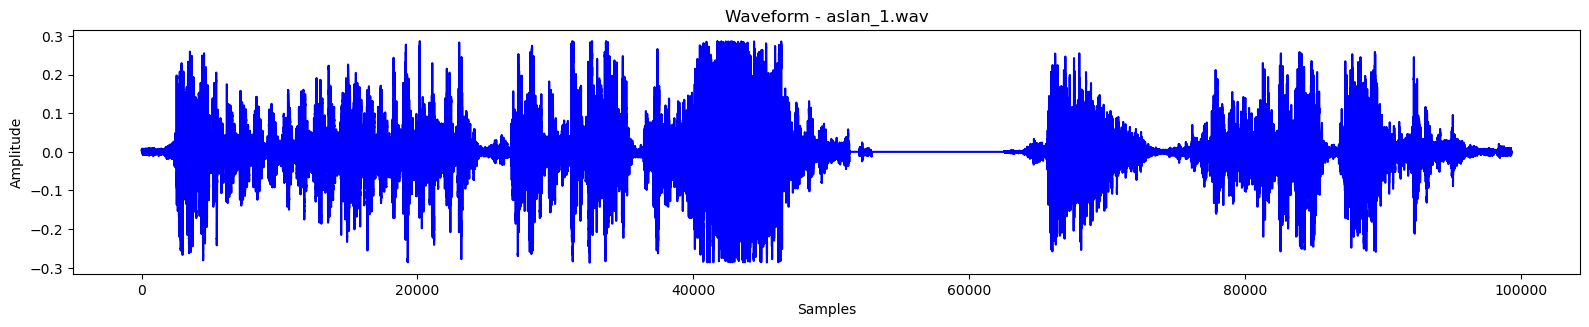


Visualizing Trimmed Silence:


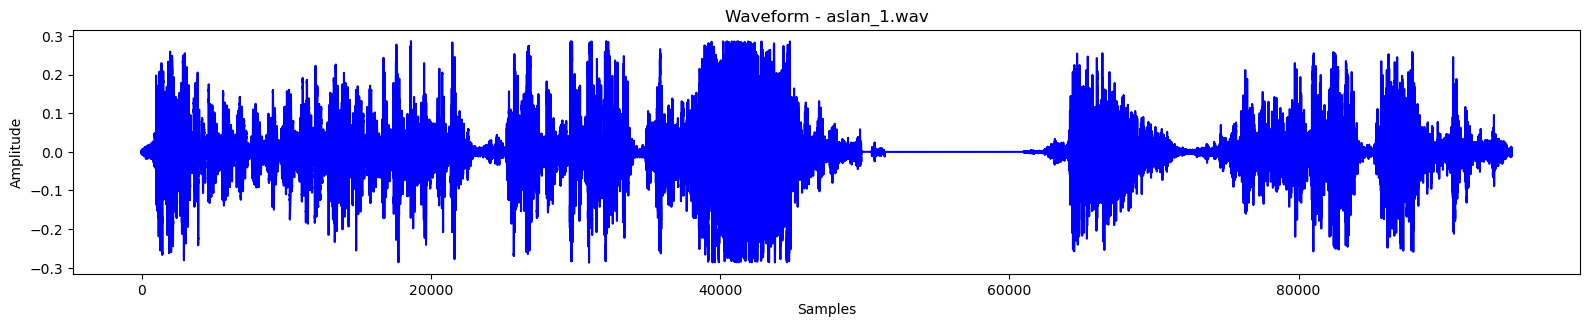

In [20]:
def visualize_audio(file_path, method, **kwargs):
    """
    Visualize the audio features after applying the preprocessing method.
    Args:
        file_path (str): Path to the audio file.
        method (function): Preprocessing method to apply.
        kwargs: Additional arguments for the preprocessing method.
    """
    audio, sr = method(file_path, **kwargs)
    
    log_mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(log_mel_spectrogram, ref=np.max)
    
    file_name = os.path.basename(file_path)
    display_audio_features(audio, log_mel_spectrogram, file_name)


print("Visualizing audio transformations...")

first_audio_file = glob.glob(os.path.join(audio_directory_path, '*.wav'))[0]

print("\nVisualizing Reduced Bit Depth (4-bit):")
visualize_audio(first_audio_file, reduce_bit_depth, bit_depth=4)

print("\nVisualizing Reduced Bit Depth (8-bit):")
visualize_audio(first_audio_file, reduce_bit_depth, bit_depth=8)

print("\nVisualizing Mono Conversion:")
visualize_audio(first_audio_file, convert_to_mono)

print("\nVisualizing Trimmed Silence:")
visualize_audio(first_audio_file, trim_silence, top_db=20)

# 8) Testing trim silence with variety of cases for top dB and combine all cases with optimal dB:


Testing with trimmed silence (top_db=0):
Accuracy for top_db=0: 0.00%

Testing with trimmed silence (top_db=5):
Accuracy for top_db=5: 48.89%

Testing with trimmed silence (top_db=10):
Accuracy for top_db=10: 66.67%

Testing with trimmed silence (top_db=15):
Accuracy for top_db=15: 73.33%

Testing with trimmed silence (top_db=20):
Accuracy for top_db=20: 75.56%

Testing with trimmed silence (top_db=25):
Accuracy for top_db=25: 75.56%

Testing with trimmed silence (top_db=30):
Accuracy for top_db=30: 77.78%

Testing with trimmed silence (top_db=35):
Accuracy for top_db=35: 77.78%

Testing with trimmed silence (top_db=40):
Accuracy for top_db=40: 73.33%

Testing with trimmed silence (top_db=45):
Accuracy for top_db=45: 73.33%

Testing with trimmed silence (top_db=50):
Accuracy for top_db=50: 71.11%

Testing with trimmed silence (top_db=55):
Accuracy for top_db=55: 73.33%

Testing with trimmed silence (top_db=60):
Accuracy for top_db=60: 73.33%

Testing with trimmed silence (top_db=65):


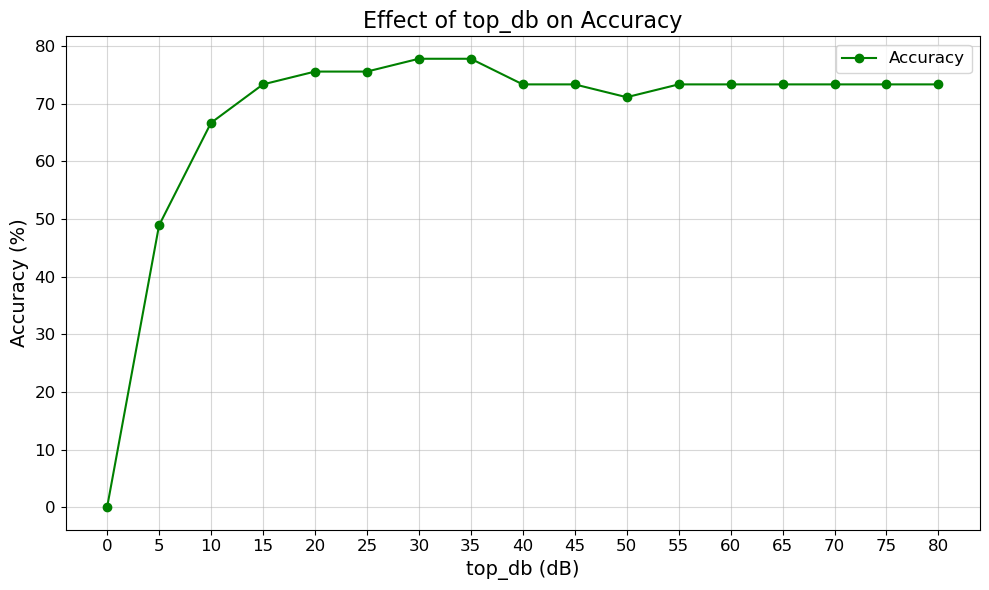

In [22]:
def test_trim_silence_multiple_top_db(directory_path, yamnet_model, class_map):
    """
    Test the model with audio files processed using silence trimming with varying top_db values
    and visualize the accuracy change.
    Args:
        directory_path (str): Path to the directory containing .wav files.
        yamnet_model: The YAMNet model instance.
        class_map (dict): Mapping of class indices to class names.
    """
    top_db_values = range(min_db, max_db, range_db)  
    accuracy_results = []

    for top_db in top_db_values:
        print(f"\nTesting with trimmed silence (top_db={top_db}):")
        results = test_modified_preprocessing(directory_path, yamnet_model, class_map, trim_silence, top_db=top_db)
        accuracy = calculate_accuracy(results)
        print(f"Accuracy for top_db={top_db}: {accuracy:.2f}%")
        accuracy_results.append(accuracy)

    plt.figure(figsize=(10, 6))
    plt.plot(top_db_values, accuracy_results, marker='o', linestyle='-', color='g', label='Accuracy')
    plt.title('Effect of top_db on Accuracy', fontsize=16)
    plt.xlabel('top_db (dB)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(alpha=0.5)
    plt.xticks(top_db_values, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

test_trim_silence_multiple_top_db(audio_directory_path, yamnet_model, class_map)

In [23]:
def apply_all_preprocessing(file_path, bit_depth=8, top_db=15):
    """
    Apply all preprocessing steps (reduce bit depth, convert to mono, trim silence) to the audio file.
    Args:
        file_path (str): Path to the audio file.
        bit_depth (int): Desired bit depth (e.g., 8 or 4).
        top_db (int): Threshold for silence trimming in decibels.
    Returns:
        processed_audio (numpy.ndarray): The processed audio signal.
        sr (int): Sample rate of the audio.
    """
    audio, sr = reduce_bit_depth(file_path, bit_depth)
    audio, sr = convert_to_mono(file_path)
    audio, sr = trim_silence(file_path, top_db)

    return audio, sr

def test_all_methods(directory_path, yamnet_model, class_map, **kwargs):
    """
    Test the model using all preprocessing methods (reduce bit depth, mono conversion, and trim silence),
    and display the audio features for the first processed file.
    Args:
        directory_path (str): Path to the directory containing .wav files.
        yamnet_model: The YAMNet model instance.
        class_map (dict): Mapping of class indices to class names.
        kwargs: Additional arguments for the preprocessing method.
    Returns:
        results (list): List of tuples containing file name, predicted class, and probability.
    """
    results = []
    wav_files = glob.glob(os.path.join(directory_path, '*.wav'))
    first_file_visualized = False

    for wav_file in wav_files:
        try:
            waveform, sr = apply_all_preprocessing(wav_file, **kwargs)
            waveform = np.clip(waveform, -1.0, 1.0)  

            scores, embeddings, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
            aggregated_scores = aggregate_scores(scores)
            top_class, top_probability = get_top_prediction(aggregated_scores, class_map)
            results.append((os.path.basename(wav_file), top_class, top_probability))

            if not first_file_visualized:
                display_audio_features(waveform, log_mel_spectrogram, os.path.basename(wav_file))
                first_file_visualized = True  

        except Exception as e:
            print(f"Error processing file {wav_file}: {e}")

    return results



Testing with all preprocessing methods applied (8-bit, mono, trimmed silence):


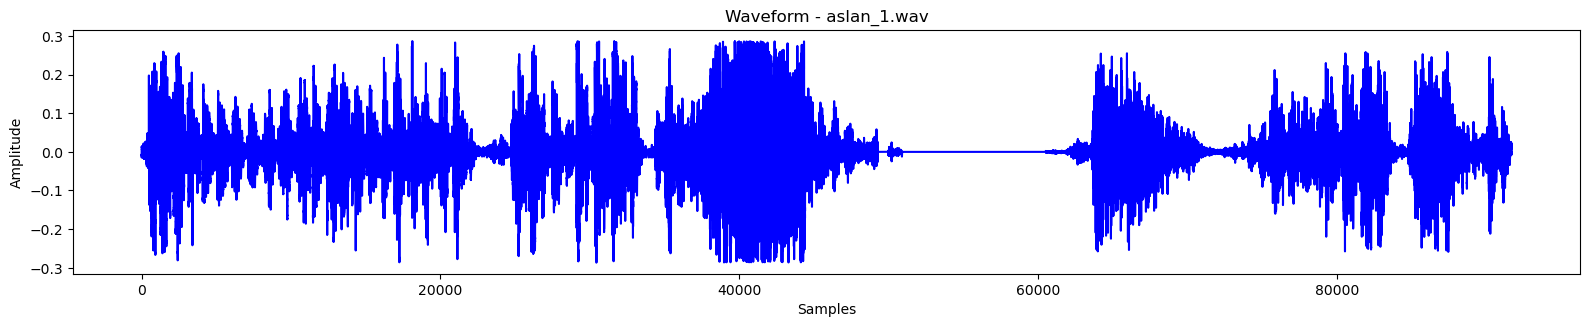

Accuracy for all methods applied:
73.33333333333333


In [24]:
bit_depth = 8
top_db = 15
print("\nTesting with all preprocessing methods applied (8-bit, mono, trimmed silence):")
results = test_all_methods(audio_directory_path, yamnet_model, class_map, bit_depth=bit_depth, top_db=top_db)
print("Accuracy for all methods applied:")
print(calculate_accuracy(results))